*Made By [Adnan](https://linktr.ee/adnaaaen)*

# ***Model Building***

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

import os
import joblib
from warnings import filterwarnings

plt.style.use("dark_background")
filterwarnings("ignore")

In [2]:
if not os.path.exists("../data/preprocessed/preprocessed.csv"):
    raise FileNotFoundError(
        "preprocessed dataset is not here, please run the 03-preprocessed.ipynb notebook"
    )

df = pd.read_csv("../data/preprocessed/preprocessed.csv")
df.head()

,city_0,city_1,city_2,city_3,city_4,pm2.5,pm10,no,no2,n_ox,nh3,co,so2,o3,benzene,toluene,is_weekend,day_time,season,aqi
0,-0.815813,-0.925448,-0.990663,-0.847216,0.76235,0.644657,0.050355,-1.393542,0.086050,0.033354,-0.002545,0.239407,1.479066,0.701922,-1.117163,-1.479028,-0.632988,-1.616656,-1.329244,5.666427
1,-0.815813,-0.925448,-0.990663,-0.847216,0.76235,0.746076,0.050355,-1.170187,-0.022855,0.105121,-0.002545,0.604834,2.566772,-0.127273,-1.117163,-1.479028,-0.632988,-0.934937,-1.329244,5.204007
2,-0.815813,-0.925448,-0.990663,-0.847216,0.76235,0.781722,0.050355,-1.277426,-0.009440,0.100697,-0.002545,0.429382,2.804722,1.112832,-1.117163,-1.479028,-0.632988,-0.934937,-1.329244,5.209486
3,-0.815813,-0.925448,-0.990663,-0.847216,0.76235,0.688063,0.050355,-1.715616,-0.239575,-0.185967,-0.002545,-0.287535,1.878814,1.417043,-1.117163,-1.479028,-0.632988,-0.934937,-1.329244,5.209486
4,-0.815813,-0.925448,-0.990663,-0.847216,0.76235,0.455894,0.050355,-1.817152,-0.431640,-0.450823,-0.002545,-0.453657,1.562342,1.721293,-1.117163,-1.479028,-0.632988,-0.253217,-1.329244,5.192957


### ***Fearure - Target split***

In [3]:
X = df.drop(["aqi"], axis=1)
Y = df["aqi"]

(X.shape), (Y.shape)

((568424, 19), (568424,))

### ***Train Test Split***

In [4]:
x_train, x_test, y_train, y_test = train_test_split(
    X, Y, random_state=323987, shuffle=True, test_size=0.3
)

(x_train.shape, y_train.shape), (x_test.shape, y_test.shape)

(((397896, 19), (397896,)), ((170528, 19), (170528,)))

### ***Model Building***

In [5]:
models = {
    "linear_regression" : LinearRegression(),
    "random_forest" : RandomForestRegressor(n_estimators=50, n_jobs=-1, max_depth=10),
    "gradient_boosting" : GradientBoostingRegressor(n_estimators=50)
}

In [7]:
cv = KFold(n_splits=5, shuffle=True, random_state=435)
model_info = []
def input_score(model_name: str, x, y):
    global model_info
    model = models[model_name]
    cur_mse = np.sqrt(-cross_val_score(model, x, y, cv=cv, scoring="neg_mean_squared_error").mean())
    cur_r_sq = cross_val_score(model, x, y, cv=cv, scoring="r2").mean()
    model_info.append({"name" : model_name , "MSE" : cur_mse, "R_sq" : cur_r_sq})

In [8]:
input_score("linear_regression", x_train, y_train)

In [9]:
model_info

{'name': 'linear_regression',
 'MSE': np.float64(0.39709885935131733),
 'R_sq': np.float64(0.6632614106841835)}

In [10]:
input_score("gradient_boosting", x_train, y_train)

In [11]:
model_info

{'name': 'gradient_boosting',
 'MSE': np.float64(0.3444320374260945),
 'R_sq': np.float64(0.7466623246097175)}

In [14]:
input_score("random_forest", x_train, y_train)

In [15]:
model_info

{'name': 'random_forest',
 'MSE': np.float64(0.3266873801982075),
 'R_sq': np.float64(0.7720477533802244)}

#### As we can see, random forest regressor work fine
#### so, tune the model

### ***HyperParameter Tuning***

In [8]:
param_grid = {
    "n_estimators" : [50, 100],
    "max_depth" : [10, 15],
    "min_samples_split" : [2, 5],
    "min_samples_leaf" : [1, 2]
}


grid_search = GridSearchCV(estimator=RandomForestRegressor(n_jobs=-1), param_grid=param_grid)
grid_search.fit(x_train, y_train)

GridSearchCV(estimator=RandomForestRegressor(n_jobs=-1),
             param_grid={'max_depth': [10, 15], 'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [50, 100]})

In [11]:
grid_search.best_params_

{'max_depth': 15,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 100}

In [13]:
best_model = RandomForestRegressor(**grid_search.best_params_)
best_model.fit(x_train, y_train)

RandomForestRegressor(max_depth=15, min_samples_leaf=2)

In [14]:
# test prediction
y_pred = best_model.predict(x_test)

In [15]:
# train prediction
y_train_pred = best_model.predict(x_train)

### ***Model Evaluation Metrics***

In [18]:
train_mse = mean_squared_error(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_rsq = r2_score(y_train, y_train_pred)

test_mse = mean_squared_error(y_test, y_pred)
test_mae = mean_absolute_error(y_test, y_pred)
test_rsq = r2_score(y_test, y_pred)

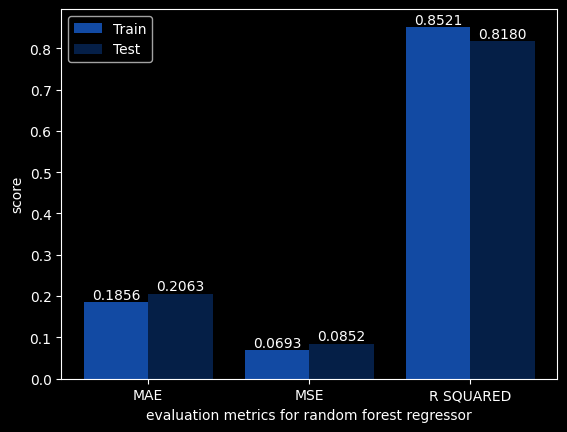

In [24]:
"""plot the metrics in train and test sets, to check overfit/underfit"""

x = ["MAE", "MSE", "R SQUARED"]
x_axis = np.arange(len(x))

ax_1 = plt.bar(
    x_axis - 0.2,
    [train_mae, train_mse, train_rsq],
    0.4,
    label="Train",
    color="#124aa3",
)
ax_2 = plt.bar(
    x_axis + 0.2,
    [test_mae, test_mse, test_rsq],
    0.4,
    label="Test",
    color="#051f47",
)

plt.bar_label(ax_1, fmt="%.4f")
plt.bar_label(ax_2, fmt="%.4f")
plt.ylabel("score")
plt.xlabel("evaluation metrics for random forest regressor")
plt.xticks(x_axis, x)
plt.legend()
plt.show()

In [26]:
X.columns

Index(['city_0', 'city_1', 'city_2', 'city_3', 'city_4', 'pm2.5', 'pm10', 'no',
       'no2', 'n_ox', 'nh3', 'co', 'so2', 'o3', 'benzene', 'toluene',
       'is_weekend', 'day_time', 'season'],
      dtype='object')

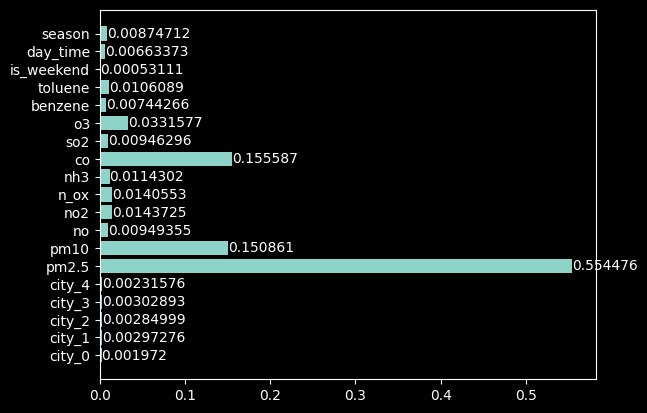

In [53]:
feature_imp = best_model.feature_importances_

ax = plt.barh(width=feature_imp, y=X.columns)
plt.bar_label(ax)
plt.show()

In [22]:
"""save model as serialized joblib file"""

if not os.path.exists("../model/trained"):
    os.mkdir("../model/trained")

joblib.dump(best_model, "../model/trained/random_forest_regressor.joblib")

['../model/trained/random_forest_regressor.joblib']

### ***Next: Create Flask Dashboard***